In [ ]:
#@title Hyberd Inception (sequential & functional API){ form-width: "2%" }
def sequential_hyperd_inception():
  model0 = Sequential()
  model0._name = 'tree_base'
  branch_0 = Sequential()
  branch_0._name = 'branch0'
  branch_1 = Sequential()
  branch_1._name = 'branch1'

  
  # 48*48
  # IMG_SIZE = 48
  model0.add(Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, 3), filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', name='conv_1'))
  model0.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_1'))
  model0.add(Activation('relu', name='active_1'))
  model0.add(Conv2D(filters=48, kernel_size=(7, 1), padding='same', kernel_initializer='he_normal', name='conv_2'))
  model0.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_2'))
  model0.add(Activation('relu',name='active_2'))
  model0.add(Conv2D(filters=48, kernel_size=(1, 7), padding='same', kernel_initializer='he_normal', name='conv_3'))
  model0.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_3'))
  model0.add(Activation('relu', name='active_3'))
  model0.add(MaxPooling2D(pool_size=(2, 2), name='max_1'))
  model0.add(Dropout(0.2, name='droup_1'))

  # 24*24
  branch_0.add(model0)
  branch_1.add(model0)
 

  branch_0.add(Conv2D(filters=64, kernel_size=(3, 1), padding='same', kernel_initializer='he_normal', name='conv_3'))
  branch_0.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_4'))
  branch_0.add(Activation('relu', name='active_4'))
  branch_0.add(Conv2D(filters=64, kernel_size=(1, 3), padding='same', kernel_initializer='he_normal' , name='conv_4'))
  branch_0.add(BatchNormalization(epsilon=1e-06,  axis=3, name='batch_5'))
  branch_0.add(Activation('relu', name='active_5'))

  branch_1.add(Conv2D(filters=64, kernel_size=(1, 7), padding='same', kernel_initializer='he_normal' , name='conv_5'))
  branch_1.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_6'))
  branch_1.add(Activation('relu', name='active_6'))
  branch_1.add(Conv2D(filters=64, kernel_size=(7, 1), padding='same', kernel_initializer='he_normal', name='conv_6' ))
  branch_1.add(BatchNormalization(epsilon=1e-06, axis=3, name='batch_7'))
  branch_1.add(Activation('relu', name='active_7'))

  merged = concatenate([branch_0.output, branch_1.output])
  merged = MaxPooling2D(pool_size=(2, 2))(merged)
  merged = Dropout(0.2)(merged)
  
  # 12*12
  merged = Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal' )(merged)
  merged = BatchNormalization(epsilon=1e-06, axis=3)(merged)
  merged = Activation('relu')(merged)
  
  merged = Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal' )(merged)
  merged = BatchNormalization(epsilon=1e-06, axis=3)(merged)
  merged = Activation('relu')(merged)
  merged = MaxPooling2D(pool_size=(2, 2))(merged)
  merged = Dropout(0.3)(merged)
  
  #  6*6
  merged = Flatten()(merged)
  merged = Dense(256, kernel_initializer='he_normal')(merged)
  merged = BatchNormalization()(merged)
  merged = Dropout(0.4)(merged)
  merged = Dense(43, activation='softmax', kernel_initializer='he_normal')(merged)
  modelMerged = Model(outputs=merged)
  return modelMerged

In [ ]:
#@title Download data set 'DONE'{ form-width: "10%" }
!pip install -q kaggle
from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip /content/gtsrb-german-traffic-sign.zip -d '/content/Model 1 resourses'
# !cp -r '/content/Model 1 resourses' '/content/drive/My Drive'

In [ ]:
#@title Mount Drive{ form-width: "10%" }
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Get Data From Drive{ form-width: "10%" }
!cp -r "/content/drive/My Drive/GTSRB_new" /content
!ln -s /content/drive/My\ Drive/ /mydrive

In [ ]:
#@title Libraries{ form-width: "10%" }

import matplotlib.pyplot as plt
import tensorflow as tf
import skimage as sk
import pandas as pd
import numpy as np
import subprocess
import pickle
import cv2
import os

from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, concatenate, Concatenate, Input, merge, Activation
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import CustomObjectScope
from keras.utils import plot_model
from keras import backend as k

from sklearn.model_selection import train_test_split
from skimage import morphology, filters, io, transform, color, exposure
from random import shuffle
from tqdm import tqdm

In [ ]:
#@title Hyperparametars{ form-width: "10%" }

# Paths
TRAIN_DIR = "/content/Model 1 resourses/Train"
TEST_DIR = "/content/Model 1 resourses/Test"

train_data_npy = '/content/drive/My Drive/GTSRB_new/train_data_hybird_Inception.npy'
train_data_label_npy = '/content/drive/My Drive/GTSRB_new/train_data_label_hybird_Inception.npy'

test_data_npy = '/content/drive/My Drive/GTSRB_new/test_data_hybird_Inception.npy'
test_data_label_npy = '/content/drive/My Drive/GTSRB_new/test_data_label_hybird_Inception.npy'

validate_data_npy = '/content/drive/My Drive/GTSRB_new/validate_data_hybird_Inception.npy'
validate_data_label_npy = '/content/drive/My Drive/GTSRB_new/validate_data_label_hybird_Inception.npy'

date = '6.8.' # 6.8 means 6/8/2020
A = 'A.' # we changed data augmentatino variables
B = 'B.' # Hybird Inception
O = 'O.' # original Inception
C = 'C.' # using normalization in pre-processing
M = 'M.' # functional model

model_name = date + M + 'InceptionWithDataAaugmentationEpoch200'
model_summary = ''
gtsrb_path =  '/content/drive/My Drive/GTSRB_new'
model_path = '/content/GTSRB_new/97.8939P1/6.8.M.InceptionWithoutDataAaugmentationEpoch30.h5'

csv_path = "/content/drive/My Drive/GTSRB_new/Test.csv"

classes = ["0","1","2","3","4","5",
           "6","7","8","9","10","11",
           "12","13","14","15","16","17",
           "18","19","20","21","22","23",
           "24","25","26","27","28","29",
           "30","31","32","33","34","35",
           "36","37","38","39","40","41","42"
           ]

IMG_SIZE = 48
# IMG_SIZE = 32
# how many samples to calculte the error
BATCH_SIZE = 16

## Flags
# 0 for vgg, 1 for inception, 2 for hybird inception
Classifire_flag = 2
Test_flag = 1
# 1 for force 
Force_train_flag = 1
Normalize_Flag = 0

In [ ]:
#@title Image Preprocessing Old{ form-width: "10%" }
def histogram_equalize(image):
    kernel =  sk.morphology.disk(30)
    img_local = sk.filters.rank.equalize(image, selem=kernel)
    return img_local

def create_label(folder_name):
    """ Create an one-hot encoded vector from folder name """
    index = classes.index(folder_name)
    return np.array([1 if i == index else 0 for i in range(43)])

def create_train_data():
    training_data = []
    for folder in tqdm(classes):
        folder_path = TRAIN_DIR + "/" + folder
        for train_img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, train_img)
            train_img_data = cv2.imread(img_path, 0)
            train_img_data = histogram_equalize(train_img_data)
            train_img_data = cv2.resize(train_img_data, (IMG_SIZE, IMG_SIZE)) / 255.0
            training_data.append([np.array(train_img_data), create_label(folder)])
    shuffle(training_data)
    np.save('train_data_vgg.npy', training_data)
    return training_data

def create_test_data():
    testing_data = []
    print('pre-processing test data')
    for test_img in (os.listdir(TEST_DIR)):
        img_path = os.path.join(TEST_DIR, test_img)
        if test_img == "GT-final_test.csv":
          continue
        test_img_data = cv2.imread(img_path, 0)
        test_img_data = histogram_equalize(test_img_data)
        test_img_data = cv2.resize(test_img_data, (IMG_SIZE, IMG_SIZE)) / 255.0
        testing_data.append([np.array(test_img_data), test_img])
    np.save('test_data_vgg.npy', testing_data)
    return testing_data

In [ ]:
#@title Image Preprocessing New{ form-width: "10%" }
def process(img):
  if Normalize_Flag == 1:
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

  min_side = min(img.shape[:-1])
  centre = img.shape[0]//2, img.shape[1]//2
  img = img[centre[0]-min_side//2:centre[0]+min_side//2,
            centre[1]-min_side//2:centre[1]+min_side//2,:]
  img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
  return img

def create_label(folder_name):
  """ Create an one-hot encoded vector from folder name """
  index = classes.index(folder_name)
  return np.array([1 if i == index else 0 for i in range(43)])

def create_data():
  training_data = []
  training_data_label = []
  print('pre-processing train data')

  training_images_path = []
  for folder in tqdm(classes):
    folder_path = TRAIN_DIR + "/" + folder
    for train_img in os.listdir(folder_path):
      training_images_path.append([os.path.join(folder_path, train_img), folder])
  shuffle(training_images_path)

  for img_path, folder in tqdm(training_images_path):
    train_img_data = process(io.imread(img_path))
    training_data.append(train_img_data)
    training_data_label.append(create_label(folder))

  testing_data = []
  testing_data_label = []
  print('pre-processing test data')
  for test_img in (os.listdir(TEST_DIR)):
    img_path = os.path.join(TEST_DIR, test_img)
    if test_img == "GT-final_test.csv":
      continue
    test_img_data = process(io.imread(img_path))
    testing_data.append(test_img_data)
    testing_data_label.append(test_img)

  training_data = np.array(training_data, dtype='float32')
  training_data_label = np.array(training_data_label)

  testing_data = np.array(testing_data, dtype='float32')
  testing_data_label = np.array(testing_data_label)

  index=np.zeros(1307,  dtype='int')
  for i in range(1307):
    index[i]=i*30+np.random.randint(0,30) 
  
  validation_data = training_data[index]
  validation_data_label = training_data_label[index]
  
  # creat the training index1
  new_index=np.setdiff1d(np.array(range(39209)), index, assume_unique=True)
  training_data=training_data[new_index]
  training_data_label=training_data_label[new_index]

  mean_image = np.mean(training_data, axis=0)
  training_data -= mean_image
  testing_data -= mean_image
  validation_data -= mean_image

  
  np.save('normalized_train_data_hybird_Inception.npy', training_data)
  np.save('normalized_train_data_label_hybird_Inception.npy', training_data_label)
  np.save('normalized_test_data_hybird_Inception.npy', testing_data)
  np.save('normalized_test_data_label_hybird_Inception.npy', testing_data_label)
  np.save('normalized_validate_data_hybird_Inception.npy', validation_data)
  np.save('normalized_validate_data_label_hybird_Inception.npy', validation_data_label)
  return training_data,training_data_label,testing_data,testing_data_label,validation_data,validation_data_label



In [ ]:
#@title Training Plots{ form-width: "10%" }

def plots(history):
    # Plot history
    # Plot training & validation accuracy values
    print(history.history.keys())
    plt.plot(history.history['accuracy'] , '-o')
    plt.plot(history.history['val_accuracy'], '-x')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='lower right')
    fig = plt.gcf()
    fig.set_size_inches(25,8)
    plt.savefig(model_name + '.acc.png')
    plt.show()

    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-x')
    plt.title('Loss for Chennai Reservoir Levels')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['Loss (training data)', 'Loss (validation data)'], loc="upper right")
    fig = plt.gcf()
    fig.set_size_inches(25,8)
    plt.savefig(model_name + '.loss.png')
    plt.show()
    print(history.history.keys())

In [ ]:
#@title Hybrid VGG{ form-width: "10%" }
def hybrid_vgg():
    model = Sequential()
    # model.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    model.add(Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,1),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="VALID"))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="VALID"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="VALID"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))

    model.add(Flatten())
    model.add(Dense(units=256,activation="relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=43, activation="softmax"))
    return model

In [ ]:
#@title Hybird Inception (functional API ) { form-width: "5%" }

def functional_hybird_inception():
  input_img = Input(shape=(48, 48, 3))

  layer_1 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(input_img)
  layer_1_b = BatchNormalization(epsilon=1e-06, axis=3)(layer_1)
  layer_2 = Conv2D(48, (7,1), padding='same', activation='relu' ,kernel_initializer='he_normal')(layer_1_b)
  layer_2_b = BatchNormalization(epsilon=1e-06, axis=3)(layer_2)
  layer_3 = Conv2D(48, (1,7), padding='same', activation='relu' ,kernel_initializer='he_normal')(layer_2_b)
  layer_3_b = BatchNormalization(epsilon=1e-06, axis=3)(layer_3)
  max_1 = MaxPool2D(pool_size=(2,2))(layer_3_b)
  drop_1 = Dropout(rate=0.2)(max_1)

  inc_1 = Conv2D(64, (3,1), padding='same', activation='relu' ,kernel_initializer='he_normal')(drop_1)
  inc_1 = BatchNormalization(epsilon=1e-06, axis=3)(inc_1)
  inc_1 = Conv2D(64, (1,3), padding='same', activation='relu' ,kernel_initializer='he_normal')(inc_1)
  inc_1 = BatchNormalization(epsilon=1e-06, axis=3)(inc_1)

  inc_2 = Conv2D(64, (1,7), padding='same', activation='relu' ,kernel_initializer='he_normal')(drop_1)
  inc_2 = BatchNormalization(epsilon=1e-06, axis=3)(inc_2)
  inc_2 = Conv2D(64, (7,1), padding='same', activation='relu' ,kernel_initializer='he_normal')(inc_2)
  inc_2 = BatchNormalization(epsilon=1e-06, axis=3)(inc_2)
  ######
  merge_layer = concatenate([inc_1, inc_2])
  ######
  max_2 = MaxPool2D(pool_size=(2,2))(merge_layer)
  drop_2 = Dropout(rate=0.2)(max_2)

  layer_4 = Conv2D(128, (3,3), padding='same', activation='relu' ,kernel_initializer='he_normal')(drop_2)
  layer_4_b = BatchNormalization(epsilon=1e-06, axis=3)(layer_4)
  layer_5 = Conv2D(256, (3,3), padding='same', activation='relu' ,kernel_initializer='he_normal')(layer_4_b)
  layer_5_b = BatchNormalization(epsilon=1e-06, axis=3)(layer_5)

  max_3 = MaxPool2D(pool_size=(2,2))(layer_5_b)
  drop_3 = Dropout(rate=0.3)(max_3)

  flat_1 = Flatten()(drop_3)
  dense_1 = Dense(256, activation='relu', kernel_initializer='he_normal')(flat_1)
  ldense_1_b = BatchNormalization()(dense_1)
  drop_4 = Dropout(rate=0.4)(ldense_1_b)
  output = Dense(43, activation='softmax', kernel_initializer='he_normal')(drop_4)

  model = Model([input_img], output)
  return model

All Data Loaded Successfully
--------------------------------
Train data shape:  (37902, 48, 48, 3)
Train labels shape:  (37902, 43)
Validation data shape:  (1307, 48, 48, 3)
Validation labels shape:  (1307, 43)
Test data shape:  (12630, 48, 48, 3)
Test labels shape:  (12630,)
Loaded model from disk
--------------------------------
Start Training
--------------------------------
Epoch 1/200
2368/2368 [==============================] - 72s 30ms/step - loss: 0.4346 - accuracy: 0.9149 - val_loss: 4.8436e-04 - val_accuracy: 1.0000
Epoch 2/200
2368/2368 [==============================] - 71s 30ms/step - loss: 0.1397 - accuracy: 0.9615 - val_loss: 0.0199 - val_accuracy: 0.9992
Epoch 3/200
2368/2368 [==============================] - 71s 30ms/step - loss: 0.0861 - accuracy: 0.9747 - val_loss: 4.8277e-04 - val_accuracy: 1.0000
Epoch 4/200
2368/2368 [==============================] - 71s 30ms/step - loss: 0.0761 - accuracy: 0.9778 - val_loss: 2.4923e-05 - val_accuracy: 1.0000
Epoch 5/200
2368/2

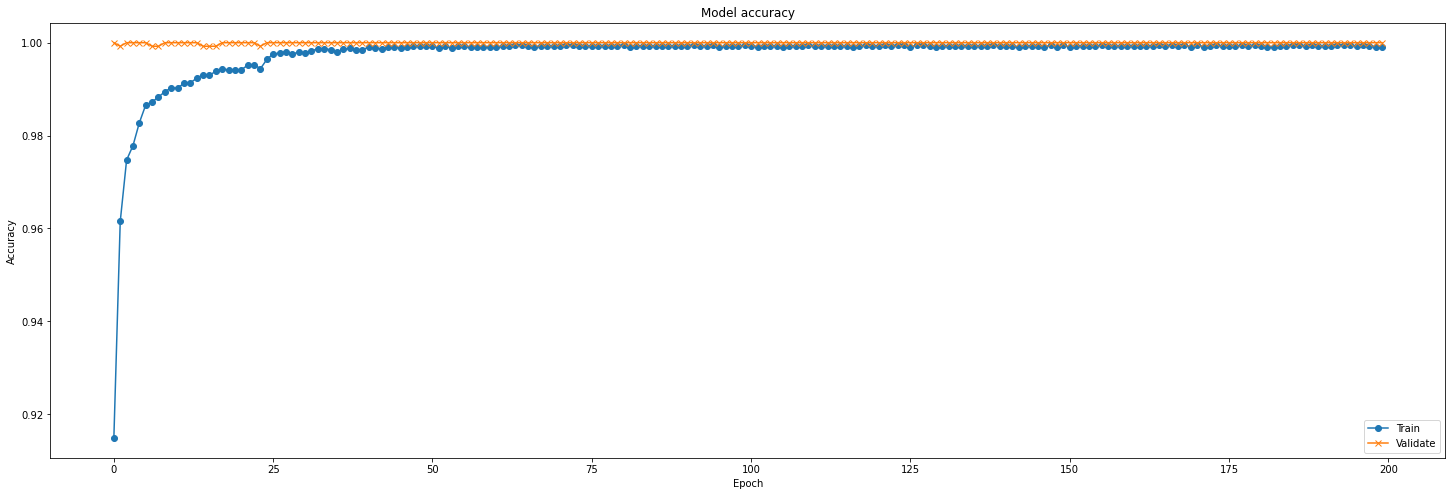

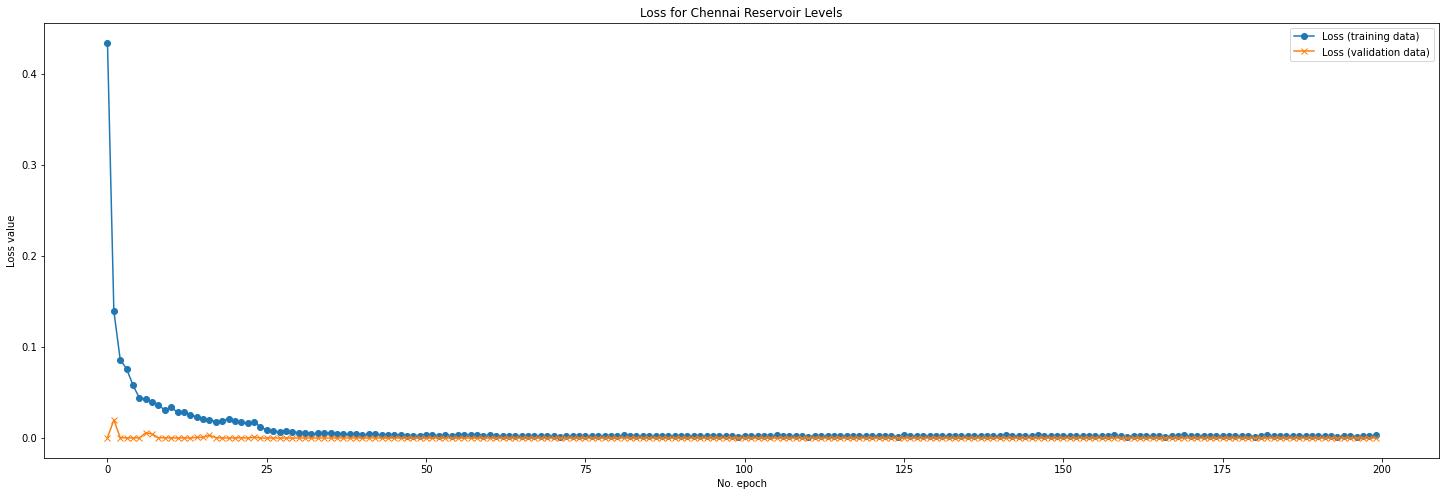

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Saved model to disk
--------------------------------
Start Testing
--------------------------------
final acc is 99.26365795724466


In [ ]:
#@title Main{ form-width: "2%" }

if os.path.exists(train_data_npy):
  X_train = np.load(train_data_npy, allow_pickle=True)
  y_train = np.load(train_data_label_npy, allow_pickle=True)
  X_test = np.load(test_data_npy, allow_pickle=True)
  y_test = np.load(test_data_label_npy, allow_pickle=True)
  X_validate = np.load(validate_data_npy, allow_pickle=True)
  y_validate = np.load(validate_data_label_npy, allow_pickle=True)
  print("All Data Loaded Successfully")
  print('--------------------------------')
else:
    X_train,y_train,X_test,y_test,X_validate,y_validate = create_data()

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_validate.shape)
print ('Validation labels shape: ', y_validate.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)


# test the classifire
# before training test history

if Classifire_flag == 0:
  model = hybrid_vgg()
elif Classifire_flag == 1:
  model = new_classifire()
else:
  model = functional_hybird_inception()

if os.path.exists(model_path) and not Force_train_flag:
  with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model = load_model(model_path)
  print("Loaded model from disk")
  print('--------------------------------')
else:
  if os.path.exists(model_path):
    model = load_model(model_path)
    print("Loaded model from disk")
    print('--------------------------------')
  print("Start Training")
  print('--------------------------------')
  model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(lr=0.001, decay=1e-6))
  # save the model

  dataGen= ImageDataGenerator(featurewise_center=False, 
                              featurewise_std_normalization=False, 
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.2,
                              shear_range=0.1,
                              rotation_range=10.,)
  
  dataGen.fit(X_train) 
  history=model.fit_generator(dataGen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                            steps_per_epoch=len(X_train) // BATCH_SIZE,
                            epochs=200,
                            validation_data=(X_validate,y_validate),
                            callbacks=[ReduceLROnPlateau('val_loss', factor=0.2, patience=20, verbose=1, mode='auto'), 
                                       ModelCheckpoint(model_name + '.h5',save_best_only=True)]
                           )
  # history=model.fit_generator(dataGen.flow(X_train, y_train,batch_size=BATCH_SIZE),steps_per_epoch= len(xtrain) // BATCH_SIZE,epochs=200,validation_data=(xvalidate,yvalidate))
  # history = model.fit(x=X_train, y=y_train, epochs=30, batch_size=BATCH_SIZE,validation_data=(X_validate, y_validate),shuffle = True)

  # model.save(model_name + '.h5')
  plots(history)
  with open(model_name + '.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
  print("Saved model to disk")
  print('--------------------------------')

# testing
if Test_flag:
  print("Start Testing")
  print('--------------------------------')  
  fields = ["Path", "ClassId"]
  data = pd.read_csv(csv_path,  usecols=fields)
  test_original = data.to_numpy()
  row , col = test_original.shape
  accepted_prediction = 0
  for img_counter in range(len(X_test)):
    test_img_name = 'Test/' + y_test[img_counter]
    x_test_4d= np.expand_dims(X_test[img_counter], axis=0)
    prediction = model.predict(x_test_4d)
    for i in range(row):
      if test_original[i][1] == test_img_name:
        class_value = test_original[i][0]
        break
    if(np.argmax(prediction) == class_value):
      accepted_prediction += 1
  acc = (accepted_prediction/row) * 100
  print("final acc is {}".format(acc))


In [ ]:
# @title Move Model Resources{ form-width: "10%" }
# path_resources = '/mydrive/GTSRB_new' + '/' + str(round(history.history['val_accuracy'][0], 4))
path_resources = '/mydrive/GTSRB_new' + '/' + str(round(acc, 4))

path_matiral_1 = '/content/' + model_name + '.h5'
path_matiral_2 = '/content/' + model_name + '.txt'
path_matiral_3 = '/content/' + model_name + '.acc.png'
path_matiral_4 = '/content/' + model_name + '.loss.png'

subprocess.call(['bash','./script.sh',path_resources,
                 path_matiral_1,
                 path_matiral_2,
                 path_matiral_3,
                 path_matiral_4])

!mkdir $path_resources
!cp  $path_matiral_1 $path_resources
!cp  $path_matiral_2 $path_resources
!cp  $path_matiral_3 $path_resources
!cp  $path_matiral_4 $path_resources

In [ ]:
#@title Show Model Summary{ form-width: "10%" }
history = pickle.load(open(model_summary, "rb"))
for variavle in history:
  print(variavle + ': ' , history[variavle])
len(model.layers)
model.summary()